# XGBoost Classification example using Concrete ML

This notebook explains how to easily define and train an XGBoost classification using Concrete ML. Then, 
this model is used to run a private inference on encrypted data using Fully Homomorphic Encryption (FHE). 
Finally, we show how the model's scores closely matches its Scikit-Learn equivalent. 

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import time

import matplotlib.pyplot as plt
import numpy
from matplotlib.colors import ListedColormap
from sklearn.datasets import fetch_openml, make_circles
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier

from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

%matplotlib inline

## 1) Example on synthetic data

Let's generate a synthetic data-set with two classes and plot it in 2D. 

In [2]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.6, random_state=0)

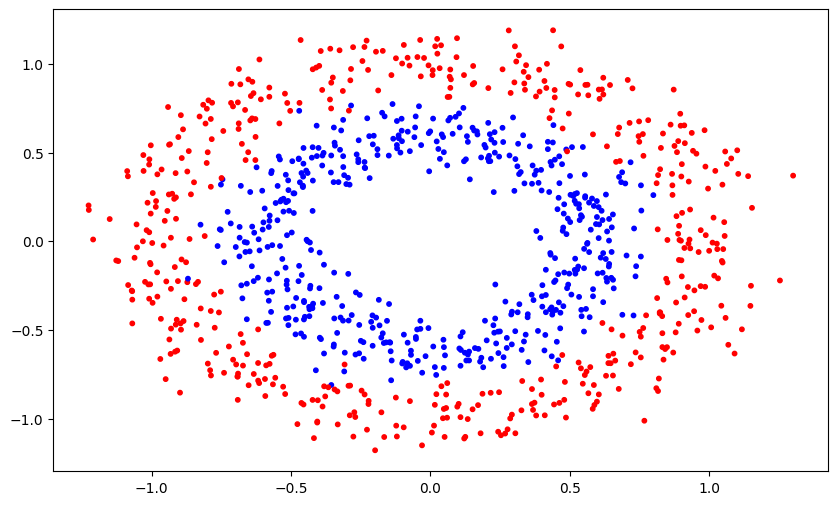

In [3]:
# Define the figure size and color
plt.figure(figsize=(10, 6))
cm_bright = ListedColormap(["#FF0000", "#FFFFFF", "#0000FF"])

plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=cm_bright)
plt.show()

### Train the models

Train both the Scikit-Learn and Concrete model using the same parameters.

In [4]:
# Define the parameters used for initialization
n_estimators = 50
max_depth = 4
n_bits = 6

# Define the parameters used for training
fit_extra_param = {"eval_metric": "logloss"}

In [5]:
sklearn_model = SklearnXGBClassifier(n_estimators=n_estimators, max_depth=max_depth)
sklearn_model.fit(X, y, **fit_extra_param);

In [6]:
concrete_model = ConcreteXGBClassifier(
    n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth
)
concrete_model.fit(X, y);

### Plot contour lines

Let's plot the contour lines for both fitted models using predicted probabilities.

In [7]:
def plot_contour(model, X, y, title=""):
    """Plot the contour lines given a model and a data-set."""
    # Create a grid will lots of point to plot the contour of the decision function
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    grid_x, grid_y = numpy.meshgrid(
        numpy.arange(x_min, x_max, 0.1), numpy.arange(y_min, y_max, 0.1)
    )

    # Predict the function value on the grid. For the Concrete ML model, this inference is done in
    # the clear, which is expected to exactly match the FHE inference.
    grid_z = model.predict_proba(numpy.c_[grid_x.ravel(), grid_y.ravel()])[:, 1]

    grid_z = grid_z.reshape(grid_x.shape)

    # Define the plot size
    plt.figure(figsize=(10, 6))

    # Plot the contour and training examples
    plt.contourf(grid_x, grid_y, grid_z, cmap=cm_bright, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1, cmap=cm_bright)
    plt.title(title)
    plt.show()

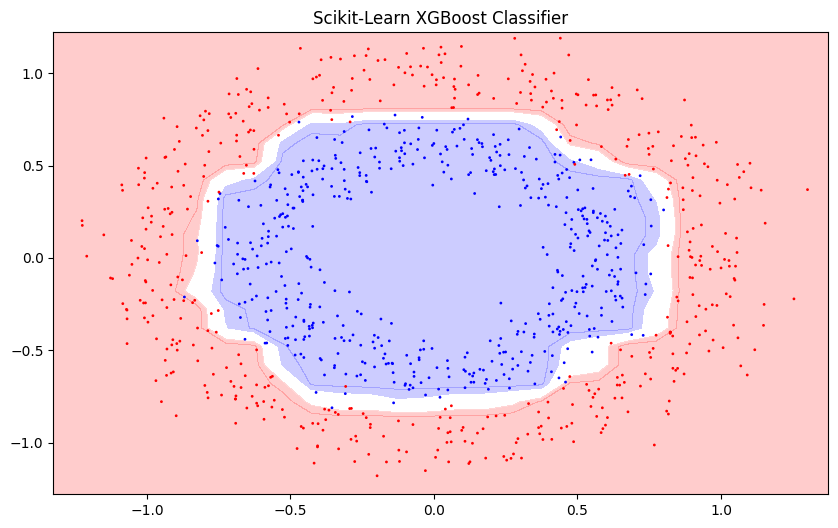

In [8]:
plot_contour(sklearn_model, X, y, title="Scikit-Learn XGBoost Classifier")

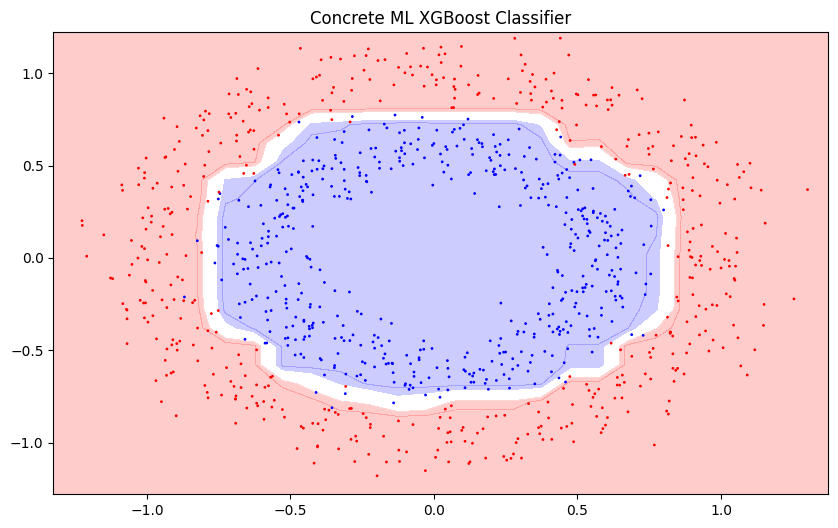

In [9]:
plot_contour(concrete_model, X, y, title="Concrete ML XGBoost Classifier")

## 2) Diabetes data example

Now, let's use the "diabetes" data-set.

In [10]:
# Load the data-set
X, y = fetch_openml(name="diabetes", as_frame=False, cache=True, return_X_y=True)

# Replace (binary) target values by integers
y[y == "tested_positive"] = 1
y[y == "tested_negative"] = 0
y = y.astype(numpy.int)

In [11]:
# Create scorer with the MCC metric
grid_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

# Define the number of estimators to consider for the following gridsearch
n_estimators = [1, 5, 10, 20] + [20 * i for i in range(2, 11)] + [50 * i for i in range(5, 11)]

### Apply Grid-Search

Let's run a GridSearch for both models

In [12]:
param_grid = {
    "max_depth": [2],
    "n_estimators": n_estimators,
}

sklearn_grid_search = GridSearchCV(
    SklearnXGBClassifier(),
    param_grid,
    cv=5,
    scoring=grid_scorer,
    error_score="raise",
    verbose=1,
)

sklearn_grid_search.fit(X, y, **fit_extra_param);

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [13]:
param_grid = {
    "n_bits": [6],
    "max_depth": [2],
    "n_estimators": n_estimators,
}

concrete_grid_search = GridSearchCV(
    ConcreteXGBClassifier(),
    param_grid,
    cv=5,
    scoring=grid_scorer,
    error_score="raise",
    verbose=1,
)

concrete_grid_search.fit(X, y);

Fitting 5 folds for each of 19 candidates, totalling 95 fits


In [14]:
# Print the best MCC score for both models
print(f"Best MCC score for Scikit-Learn: {sklearn_grid_search.best_score_:.2f}")
print(f"Best MCC score Concrete ML: {concrete_grid_search.best_score_:.2f}")

Best MCC score for Scikit-Learn: 0.48
Best MCC score Concrete ML: 0.52


### Plot the MCC score by number of estimators

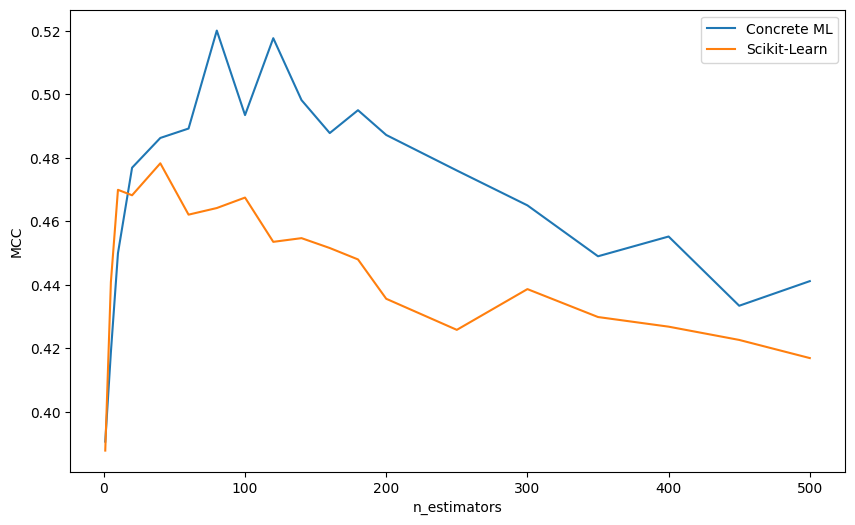

In [15]:
# Define the figure size
plt.figure(figsize=(10, 6))

# Plot the mean_test_score of both model along the n_estimators hyper parameter
plt.plot(
    concrete_grid_search.cv_results_["param_n_estimators"],
    concrete_grid_search.cv_results_["mean_test_score"],
    label="Concrete ML",
)
plt.plot(
    sklearn_grid_search.cv_results_["param_n_estimators"],
    sklearn_grid_search.cv_results_["mean_test_score"],
    label="Scikit-Learn",
)
plt.xlabel("n_estimators")
plt.ylabel("MCC")
plt.legend()
plt.show()

## 3) Execute the Inference in FHE

We now use the best initialization parameters found for the "diabetes" data-set in order to define 
our models. 

In [16]:
best_params_sklearn = sklearn_grid_search.best_params_
print(f"Best parameters found for the Scikit-Learn model: {best_params_sklearn}")

best_params_concrete = concrete_grid_search.best_params_
print(f"Best parameters found for the Concrete ML model: {best_params_concrete}")

Best parameters found for the Scikit-Learn model: {'max_depth': 2, 'n_estimators': 40}
Best parameters found for the Concrete ML model: {'max_depth': 2, 'n_bits': 6, 'n_estimators': 80}


In [17]:
# Define the Concrete ML and Scikit-Learn models
concrete_model = ConcreteXGBClassifier(**best_params_concrete)
sklearn_model = SklearnXGBClassifier(**best_params_sklearn)

# Split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Fit both models
concrete_model.fit(X_train, y_train, **fit_extra_param)
sklearn_model.fit(X_train, y_train, **fit_extra_param);

### Compile and Generate the Keys

Compiling the Concrete ML model builds the underlying FHE circuit needed for running the inference
in FHE. Once this is done, the FHE keys can be generated.

In [18]:
# Compile the Concrete ML model using the training data
circuit = concrete_model.compile(X_train)

In [19]:
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bits circuit")

# Generate the key
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Generating a key for an 8-bits circuit
Key generation time: 0.47 seconds


### Evaluate the Models

We then measure both models' accuracy and compare them. For the Concrete ML model, the inference is
done in the clear using FHE simulation in order to make computations faster. We can observe that the
accuracy is slightly below the one from Scikit-Learn, which is due to some quantization artifacts. 

In [20]:
# Compute the predictions using the Scikit-Learn model
y_pred_sklearn = sklearn_model.predict(X_test)

# Compute the predictions using the Concrete ML model with FHE simulation
y_pred_simulated = concrete_model.predict(X_test, fhe="simulate")

In [21]:
print("Accuracy scores:")
print(
    f"- Scikit-Learn (clear floating points): {accuracy_score(y_test, y_pred_sklearn)*100:.2f}%\n"
    f"- Concrete ML (clear quantized): {accuracy_score(y_test, y_pred_simulated)*100:.2f}\n"
)

Accuracy scores:
- Scikit-Learn (clear floating points): 71.43%
- Concrete ML (clear quantized): 68.83



### FHE Execution

Finally, we execute the inference in FHE on a test sub-set and observe that the predictions are
exactly matching the ones from the clear execution.

In [22]:
N_SAMPLE_FHE = 10

# Pick N_SAMPLE_FHE random samples from the test set
idx_test = numpy.random.choice(X_test.shape[0], N_SAMPLE_FHE, replace=False)
X_test_fhe = X_test[idx_test]
y_test_fhe = y_test[idx_test]

# Compute the predictions using the Concrete ML (quantized) model in the clear
y_preds_clear = concrete_model.predict(X_test_fhe)

# Compute the predictions using the Concrete ML model in FHE
time_begin = time.time()
y_preds_fhe = concrete_model.predict(X_test_fhe, fhe="execute")
print(f"FHE execution time: {(time.time() - time_begin) / len(X_test_fhe):.2f} seconds per sample")

FHE execution time: 0.67 seconds per sample


In [23]:
# Compare the clear quantized inference vs FHE inference
print(
    f"{(y_preds_fhe == y_preds_clear).sum()}/{N_SAMPLE_FHE} "
    "FHE predictions match the clear quantized predictions"
)

10/10 FHE predictions match the clear quantized predictions
